In [27]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Dropout
from keras.optimizers import Adam
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
GRAIN_TYPE = 'Wheat'
URL = "../../Datasets/processed/" + GRAIN_TYPE + ".csv"
df = pd.read_csv(URL)
df = pd.get_dummies(df, columns=['Variety'])
# Drop any columns that are 'Unnamed: X'
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.drop('Phase', axis=1)
df = df.drop('Attn', axis=1)
df = df.drop('Density', axis=1)
df['d(cm)'] = df['d(cm)'].astype('category')

# Apply one-hot encoding to 'd(cm)' because it is only ever four differne values
df = pd.get_dummies(df, columns=['d(cm)'])
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df)

# Generator
def build_generator(latent_dim):
    model = Sequential([
        Dense(256, use_bias=False, input_dim=latent_dim),
        BatchNormalization(),
        LeakyReLU(),
        Dense(512),
        BatchNormalization(),
        LeakyReLU(),
        Dense(1024),
        BatchNormalization(),
        LeakyReLU(),
        Dense(np.prod(df.shape[1]), activation='tanh'),
        Reshape((df.shape[1],))
    ])
    return model

# Discriminator
def build_discriminator(input_shape):
    model = Sequential([
        Flatten(input_shape=(input_shape,)),
        Dense(512),
        LeakyReLU(),
        Dropout(0.3),
        Dense(256),
        LeakyReLU(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

latent_dim = 100  # You can experiment with this value
generator = build_generator(latent_dim)
discriminator = build_discriminator(df.shape[1])

# Compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Combined model (generator + discriminator)
discriminator.trainable = False  # For the combined model, only train the generator

gan_input = tf.keras.Input(shape=(latent_dim,))
fake_data = generator(gan_input)
gan_output = discriminator(fake_data)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Training loop
def train_gan(generator, discriminator, gan, scaled_data, epochs=10000, batch_size=32, latent_dim=100):
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, scaled_data.shape[0], batch_size)
        real_data = scaled_data[idx]
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_data = generator.predict(noise)
        
        real_y = np.ones((batch_size, 1))
        fake_y = np.zeros((batch_size, 1))
        
        d_loss_real = discriminator.train_on_batch(real_data, real_y)
        d_loss_fake = discriminator.train_on_batch(gen_data, fake_y)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        
        if epoch % 1000 == 0:
            print(f"Epoch: {epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]")

train_gan(generator, discriminator, gan, scaled_data, epochs=20000, batch_size=32, latent_dim=latent_dim)

1/1 [==============================] - 0s 46ms/step
Epoch: 0 [D loss: 0.7354679703712463] [G loss: 0.750715970993042]
1/1 [==============================] - 0s 8ms/step
Epoch: 1000 [D loss: 0.6248062551021576] [G loss: 1.135481595993042]
1/1 [==============================] - 0s 8ms/step
Epoch: 2000 [D loss: 0.5371907353401184] [G loss: 1.0992733240127563]
1/1 [==============================] - 0s 8ms/step
Epoch: 3000 [D loss: 0.6073636412620544] [G loss: 1.1774098873138428]
1/1 [==============================] - 0s 7ms/step
Epoch: 4000 [D loss: 0.5489916205406189] [G loss: 1.2178547382354736]
1/1 [==============================] - 0s 8ms/step
Epoch: 5000 [D loss: 0.5622688233852386] [G loss: 1.47898530960083]
1/1 [==============================] - 0s 11ms/step
Epoch: 6000 [D loss: 0.48849348723888397] [G loss: 1.1186349391937256]
1/1 [==============================] - 0s 8ms/step
Epoch: 7000 [D loss: 0.46005310118198395] [G loss: 1.413252830505371]
1/1 [==============================]

In [28]:
latent_dim = 100  # Or whatever you used during training
number_of_samples = len(df)  # Generate as many synthetic samples as in your real dataset

# Generate random noise
random_noise = np.random.normal(0, 1, size=(number_of_samples, latent_dim))

# Generate synthetic data
synthetic_data = generator.predict(random_noise)

# If you applied MinMax scaling to your data, inverse transform the synthetic data
synthetic_data_rescaled = scaler.inverse_transform(synthetic_data)
frequency_index = df.columns.get_loc("Freq")
synthetic_data_rescaled[:, frequency_index] = np.round(synthetic_data_rescaled[:, frequency_index])

26/26 [==============================] - 0s 585us/step


*Convert new data to CSV format*

In [63]:
# Example synthetic data DataFrame (replace with your actual synthetic_data_df)
synthetic_data_df = pd.DataFrame(data=df)

# Function to recombine one-hot encoded columns back to a single column
def recombine_one_hot_columns(df, prefix):
    one_hot_cols = [col for col in df.columns if col.startswith(prefix)]
    # Create a mapping from one-hot encoded column back to the original value (you'll need to adjust this)
    mapping = {col: col.replace(prefix, '') for col in one_hot_cols}
    
    # Determine the active one-hot encoded column for each row
    df[f'{prefix.strip("_")}'] = df[one_hot_cols].idxmax(axis=1).map(mapping)
    
    # Drop the original one-hot encoded columns
    df.drop(columns=one_hot_cols, inplace=True)

# Assuming the prefixes are 'Variety_' and 'd(cm)_'
recombine_one_hot_columns(synthetic_data_df, 'Variety_')
recombine_one_hot_columns(synthetic_data_df, 'd(cm)_')

# Ensure the DataFrame only includes the specified columns
required_columns = ['Variety', 'Freq', 'M%', 'Phase_Corr', 'Permittivity_real', 'Permittivity_imaginary', 'd(cm)']
adjusted_synthetic_data = synthetic_data_df[required_columns]

# Save the adjusted synthetic data
adjusted_synthetic_data.to_csv('generated_data_wheat.csv', index=False)


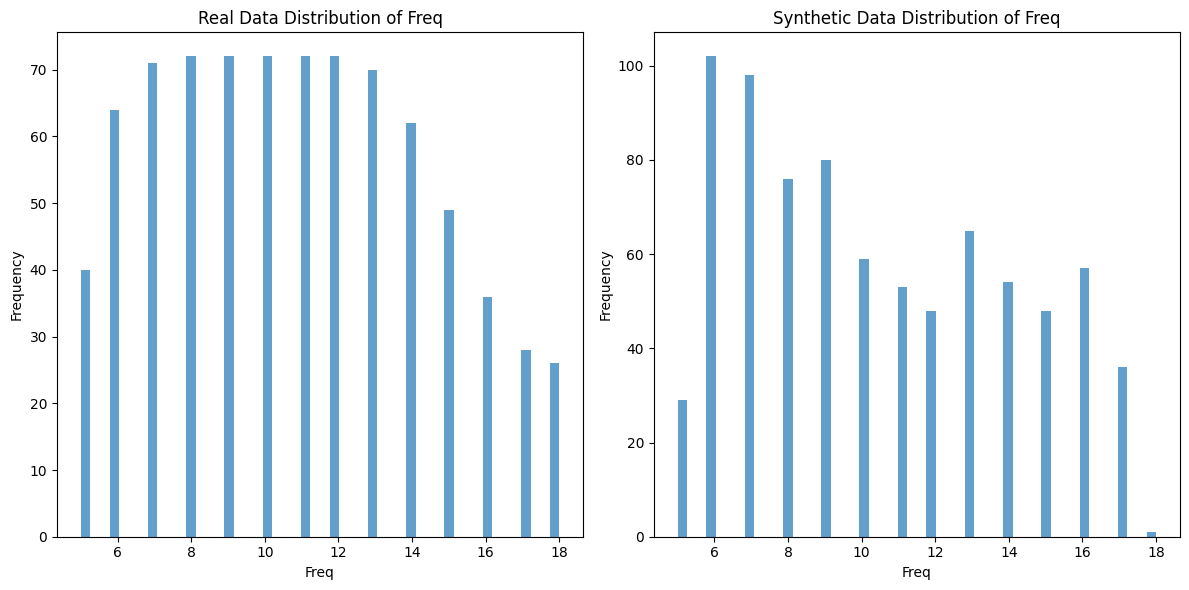

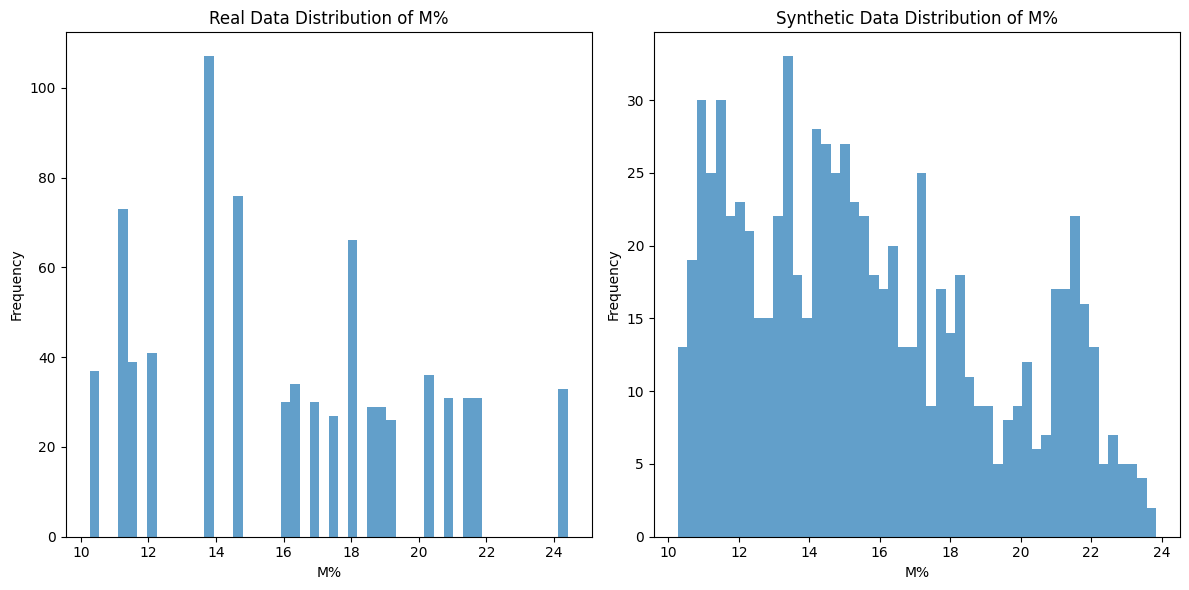

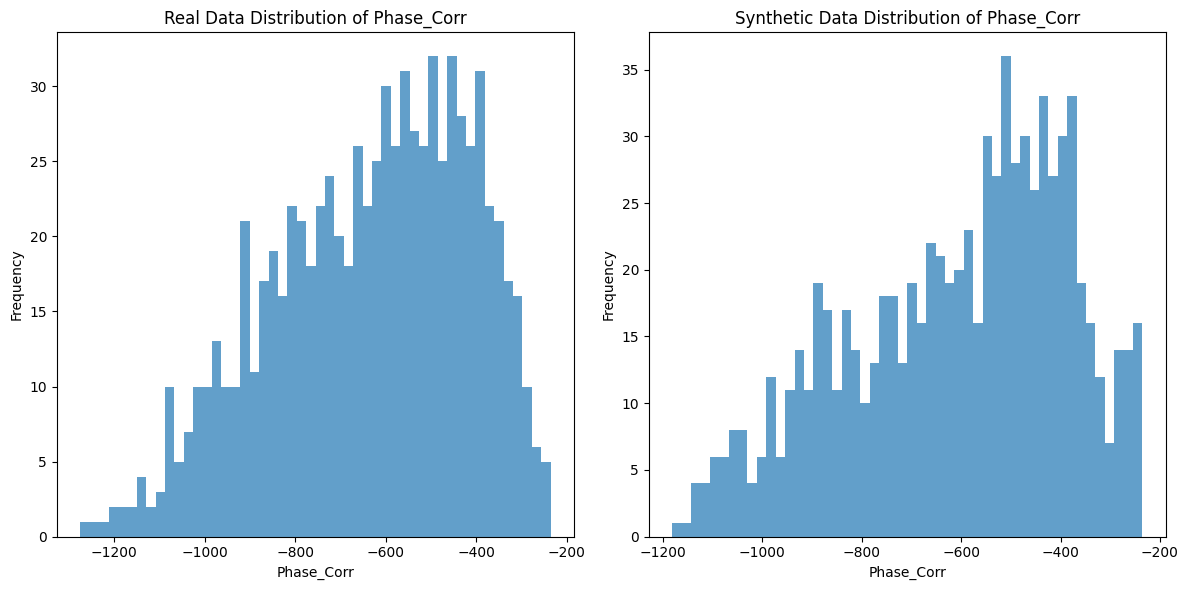

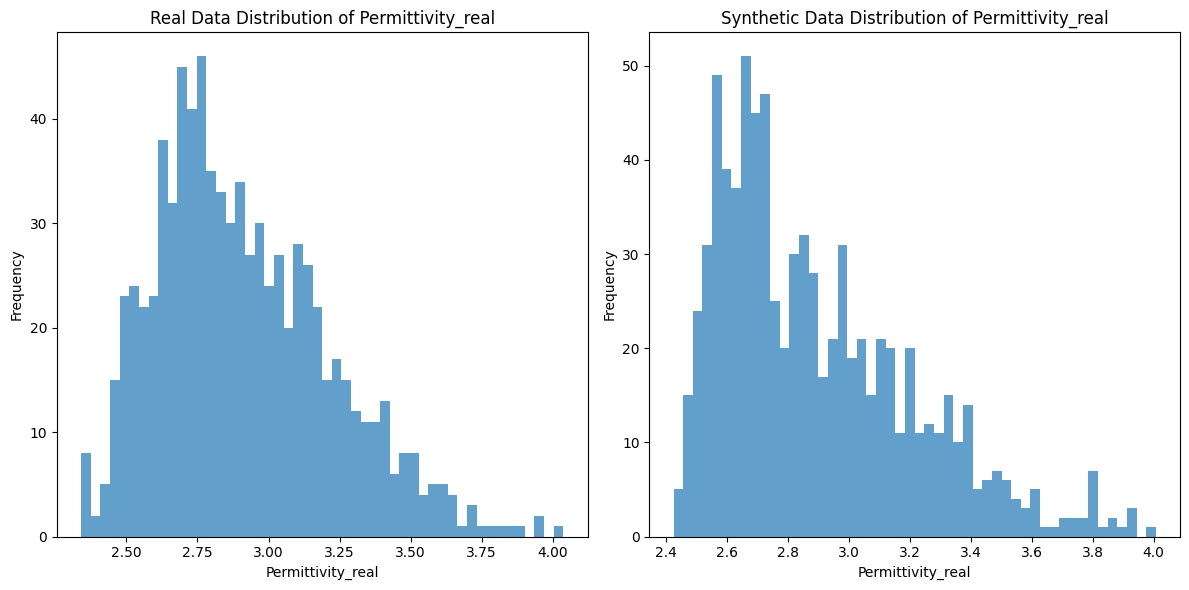

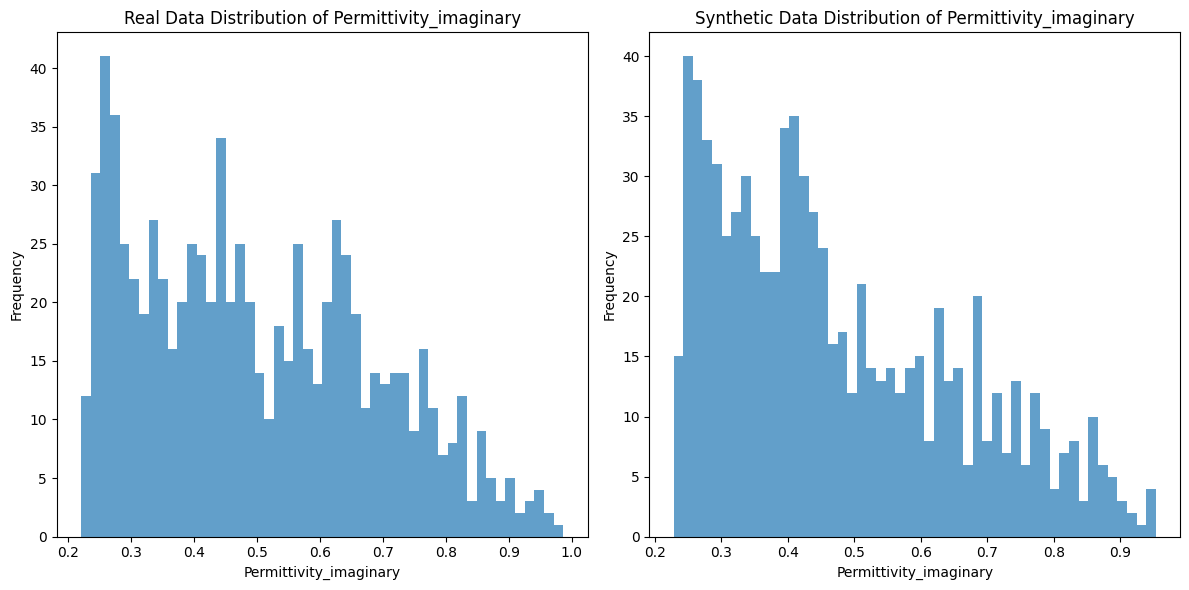

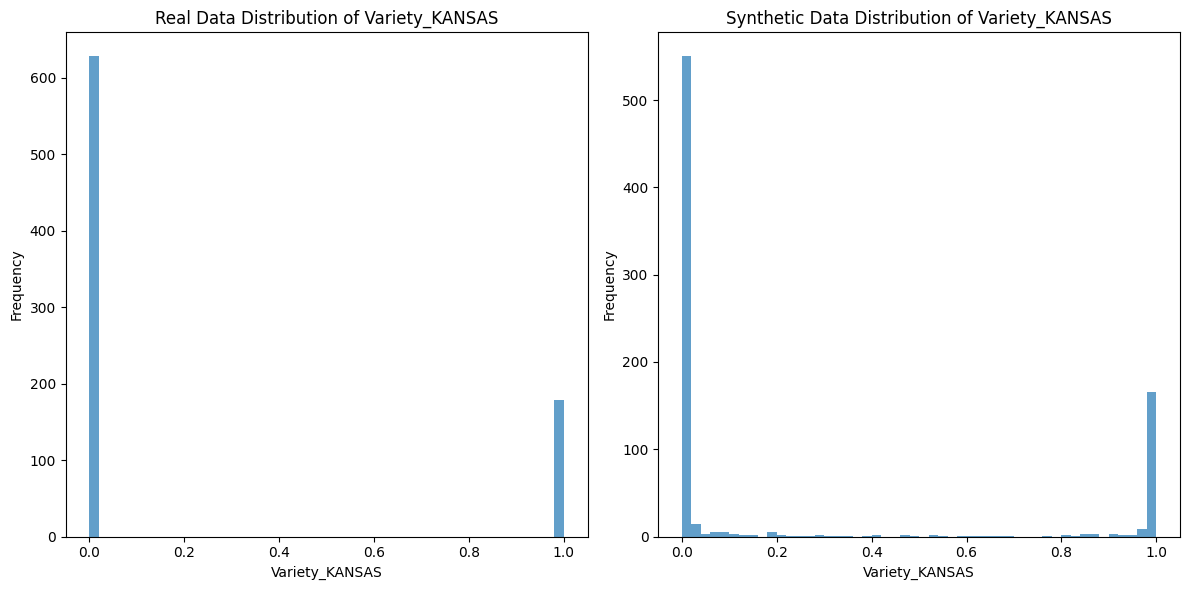

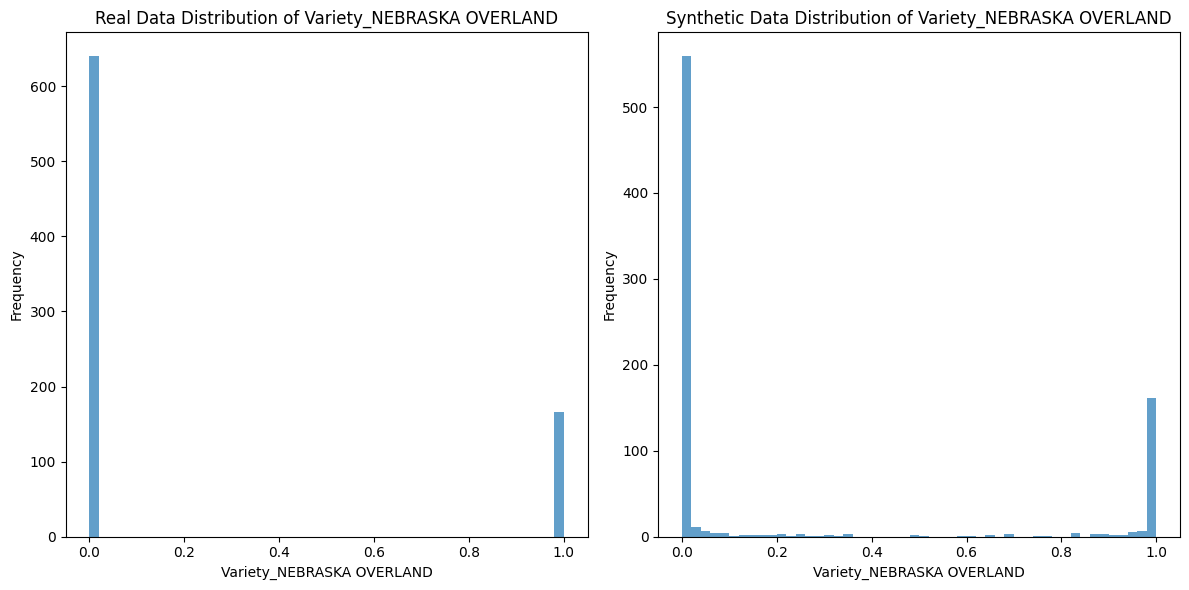

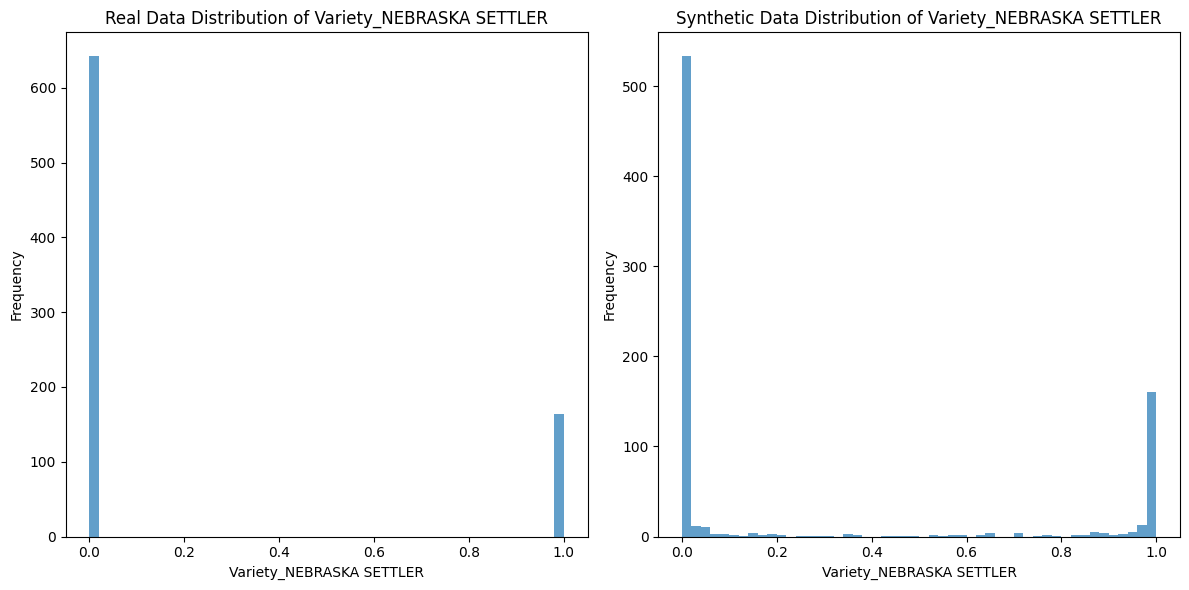

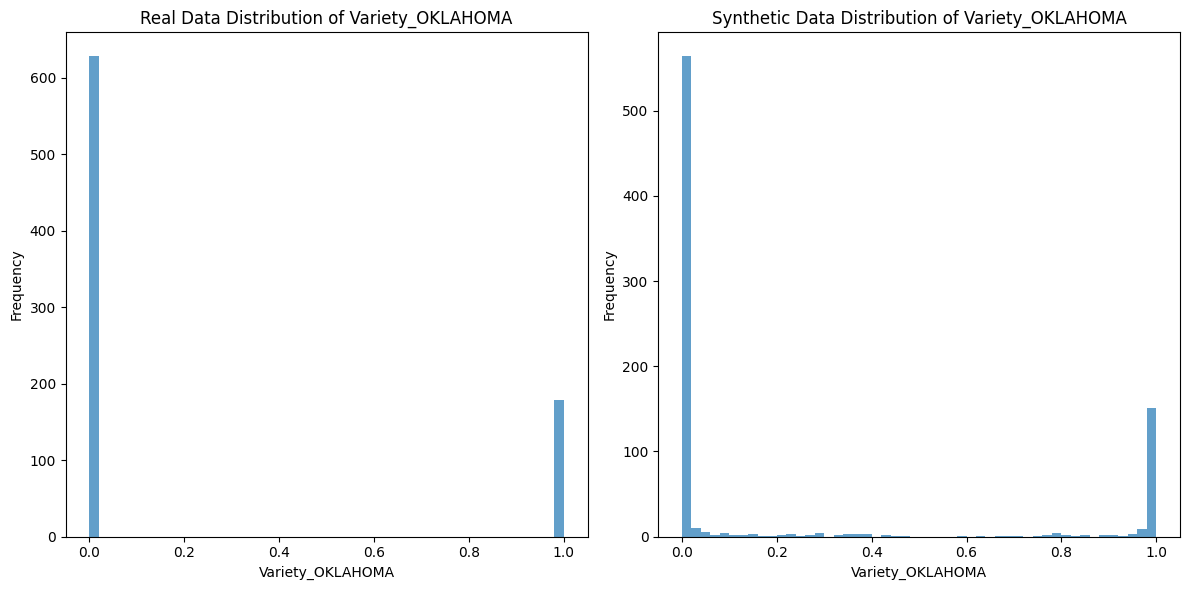

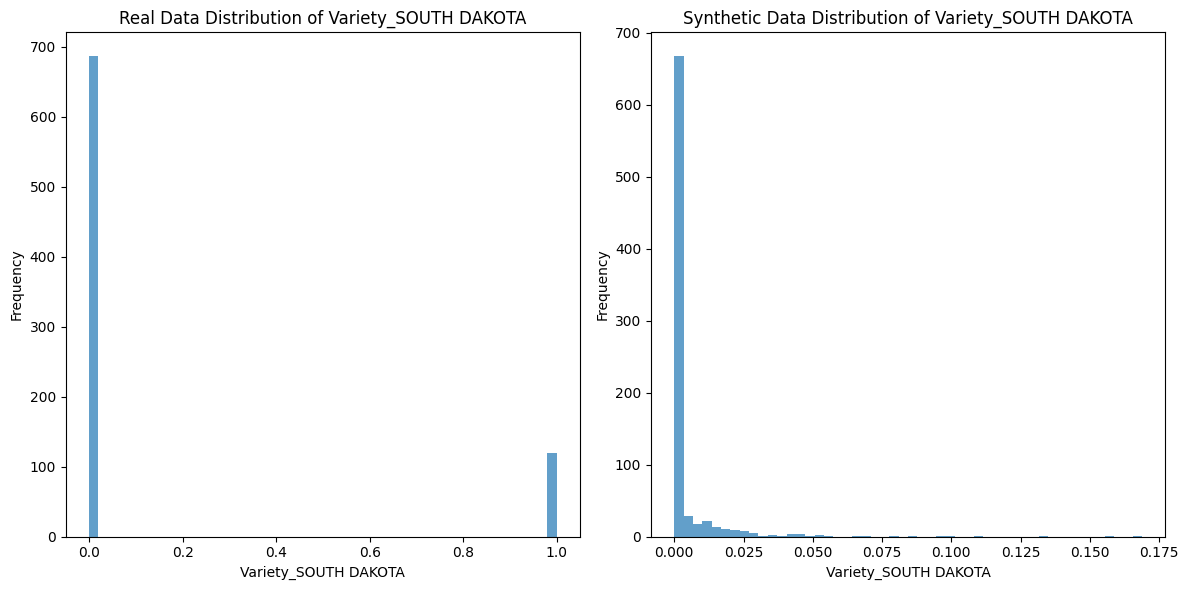

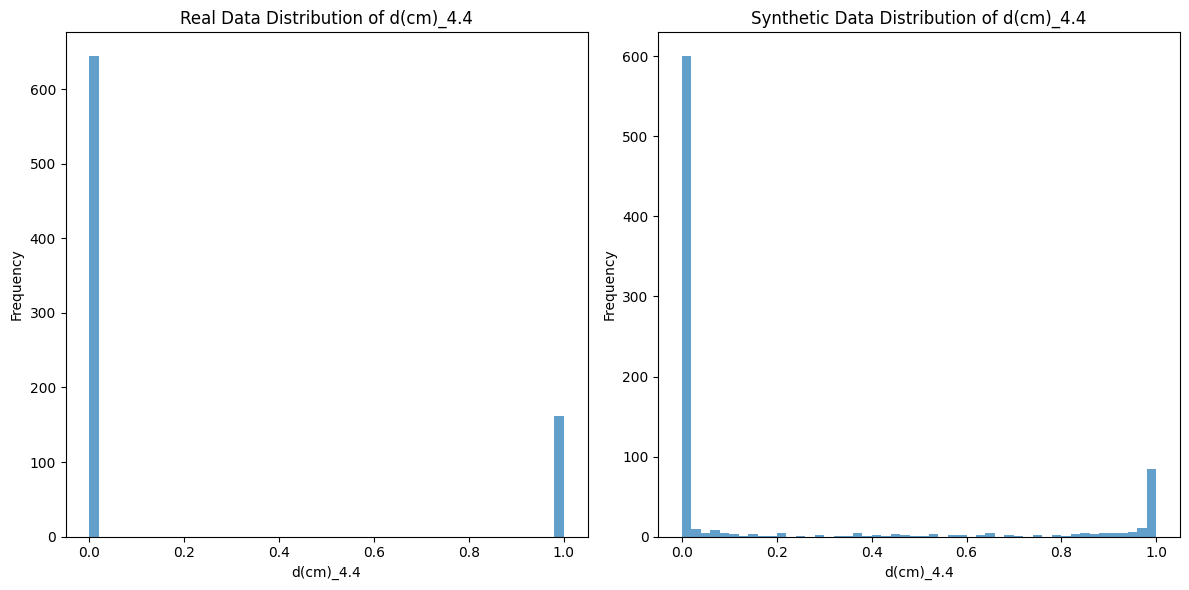

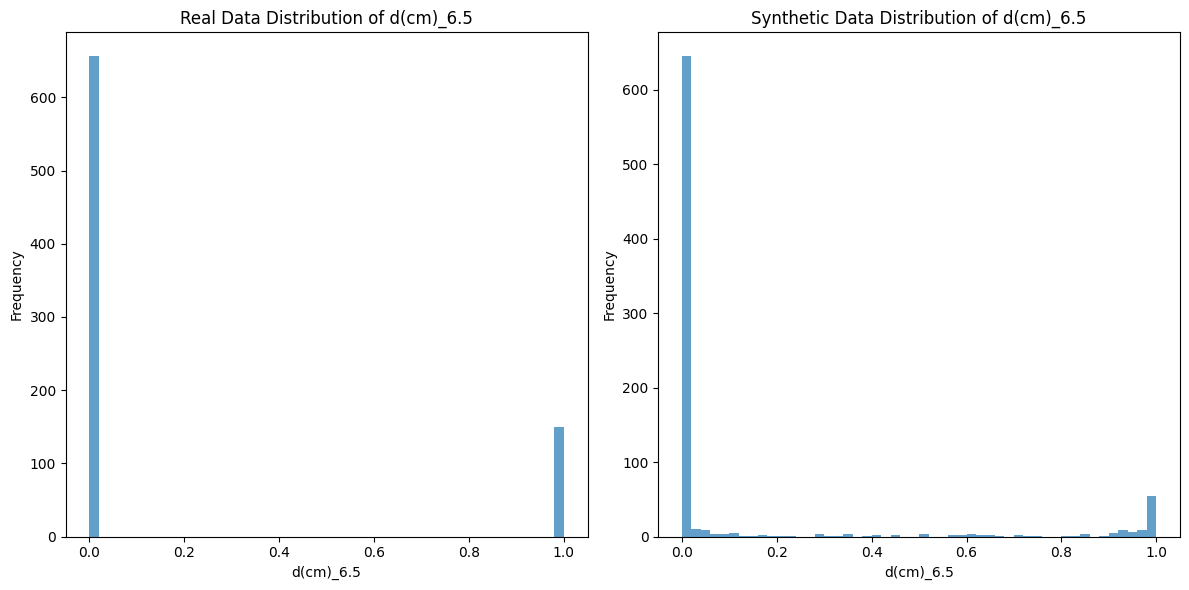

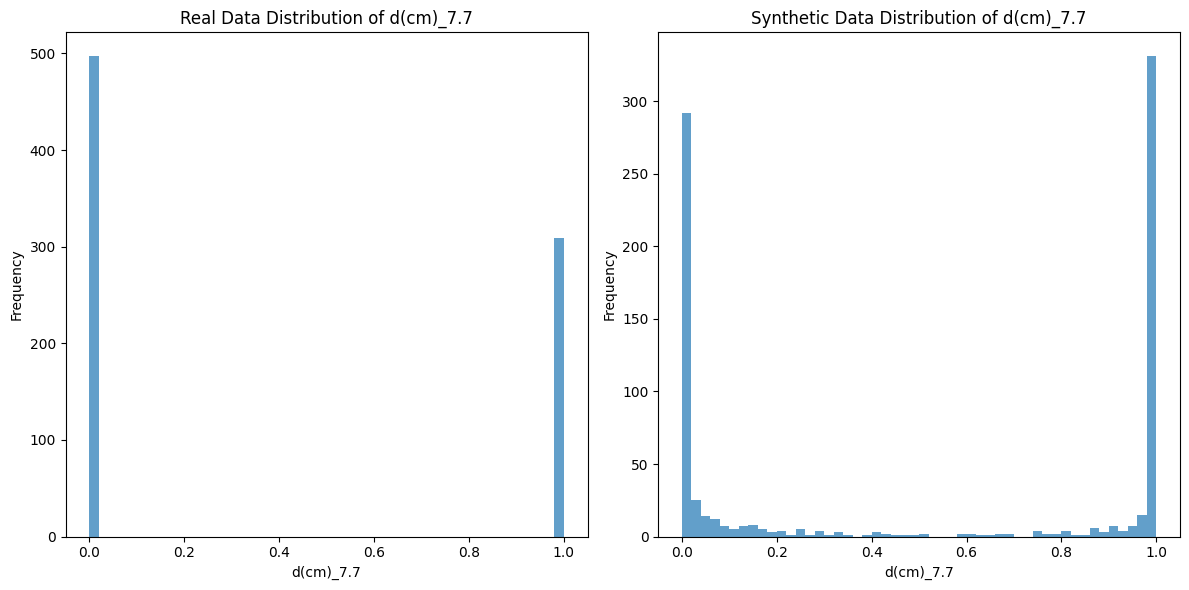

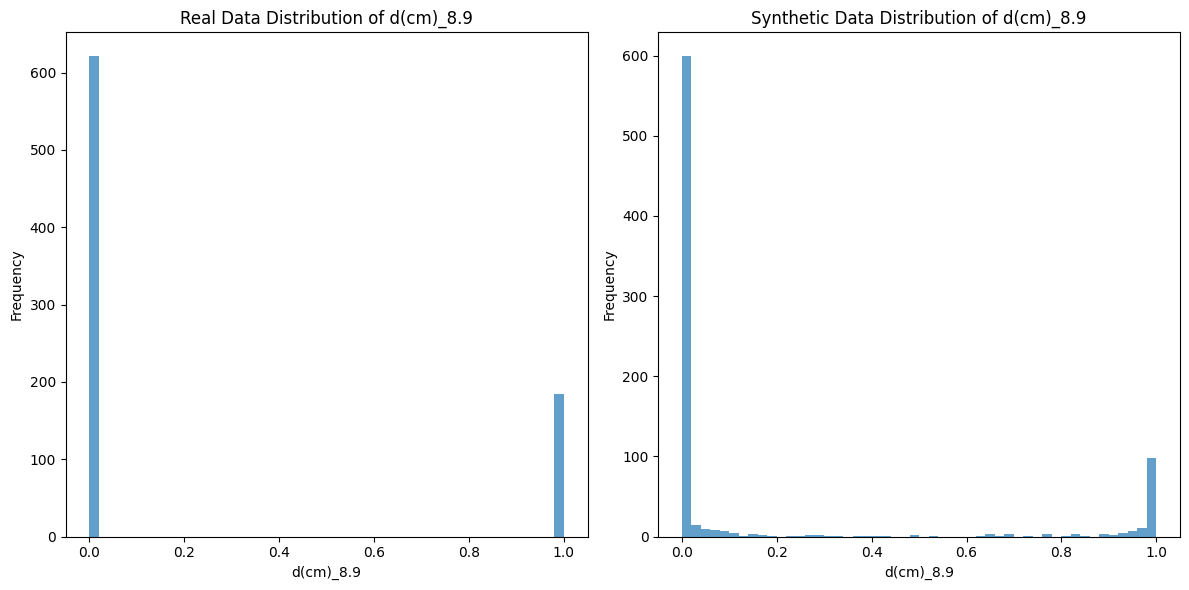

In [29]:
import matplotlib.pyplot as plt

# Assuming 'df' is your real dataset DataFrame and 'synthetic_data_rescaled' is a numpy array of your synthetic data
# Make sure 'synthetic_data_rescaled' is scaled back to the original scale of 'df'

# Iterate over each column in the DataFrame
for feature_name in df.columns:
    feature_index = df.columns.get_loc(feature_name)
    
    # Plotting the distribution of the current feature from both datasets
    plt.figure(figsize=(12, 6))
    
    # Real data
    plt.subplot(1, 2, 1)
    plt.hist(df[feature_name], bins=50, alpha=0.7, label='Real Data')
    plt.title(f'Real Data Distribution of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    
    # Synthetic data
    plt.subplot(1, 2, 2)
    plt.hist(synthetic_data_rescaled[:, feature_index], bins=50, alpha=0.7, label='Synthetic Data')
    plt.title(f'Synthetic Data Distribution of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()


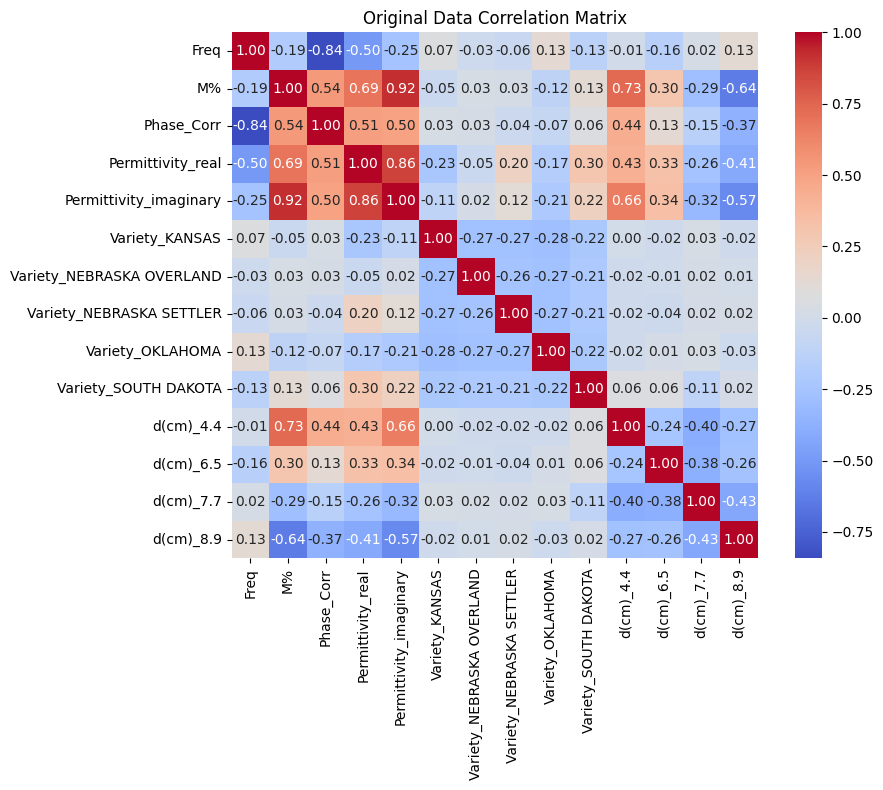

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the synthetic data to a DataFrame with the same column names as the original dataset
synthetic_df = pd.DataFrame(synthetic_data_rescaled, columns=df.columns)

# Calculate the correlation matrices for both datasets
corr_original = df.corr()
corr_synthetic = synthetic_df.corr()

# Increase the figure size for better readability
plt.figure(figsize=(10, 8))

# Plot the heatmap for the original dataset's correlation matrix on the first line
sns.heatmap(corr_original, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Original Data Correlation Matrix')

# Plot the heatmap for the synthetic dataset's correlation matrix on the second line

plt.tight_layout()  # Adjust layout to not overlap
plt.show()
